Нужные мне библиотеки

In [46]:
# torch and libs
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# own modules
from ResNetGenerator import Generator
from ResNetDescriminator import Discriminator

# utils
from torchvision.datasets import CIFAR10, CIFAR100
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from time import time
from dgm_utils import show_samples 
from IPython.display import clear_output

from typing import Callable, Optional

# global vars|
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

Эксперименты с прошлым заданием выявели много багов в моем коде. В первую очередь никуда не годятся мои ResNet Block. Из-за их архитектуры происходил mode colaps.
Для начала я попробую простые сетки, которые представлены в туториале: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

### Generative model
Здесь и в критике последовательное развертывание и свертывание картинки.

In [47]:
class Generator(nn.Module):
    def __init__(self, noise_dim, out_shape):
        super(Generator, self).__init__()
        ngf = 32
        self.out_shape = out_shape
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(noise_dim, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, out_shape[0], 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_shape[0]),
            nn.Sigmoid(),
            # state size. (ngf) x 32 x 32
        )

    def forward(self, input):
        input = input.unsqueeze(-1).unsqueeze(-1)
        img = self.main(input)
        assert img.shape[1:] == self.out_shape
        return img

Критик

In [48]:
class Discriminator(nn.Module):
    def __init__(self,input_shape):
        super(Discriminator, self).__init__()
        ndf = 32
        self.input_shape = input_shape
        self.main = nn.Sequential(
            # state size. 3 x 32 x 32
            nn.Conv2d(3, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            # nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

В статье переформулируется поведение. Выход критика $V_\omega(x)$ теперь $\mathbb{R}$ (я закоментил последнюю сигмоиду в критике). И вводится альтернативный слой активации который в статье называется $g_f$ и зависит от f-дивергенции, которую мы выбрали.

Далее нам нужно оптимизировать вот такой лосс:
$$
F(\theta, \omega) = \mathbb{E}_{x\sim P}[g_f (V_\omega(x))] + \mathbb{E}_{x\sim Q_\theta}[-f^*(g_f(V_\omega(x)))]
$$ 

При оптимизации критика мы явно максимизируем эту функцию.
При оптимизации генератора первое слагаемое никак не зависит от параметров генератора $\theta$ поэтому оптимизируется только второе. Как и в ванильном гане вместо минимизации всего второго слагаемого, будем максимизировать $\mathbb{E}_{x\sim Q_\theta}[g_f(V_\omega(x))]$. Что также явно записано в шаге генератора.

In [49]:
class fGAN(nn.Module):
    def __init__(self, input_shape, batch_size, 
                 noise_fn, data_fn,
                 gf, f_star_gf,
                 lr_D=1e-3, lr_G=2e-4,
                 noise_dim = 128,
                 flw = 1,
                 non_saturating=False,
                 ):
        """
        GAN 
        Args:
        input_shape: shape of the image
        noise_fn: function that generate latent vector :pytorch Tensor
        data_fn: function that return real data batches
        gf: alternarive activasion layer
        f_star_gf: composite of gf and f-criterion function
        lr_D: learning rate of critic
        lr_G: learning rate of Generator
        noise_dim: size of latent vector
        """
        super().__init__()
        self.batch_size = batch_size

        self.gf = gf
        self.f_star_gf = f_star_gf

        self.non_saturating = non_saturating 
        self.noise_fn = noise_fn
        self.data_fn = data_fn
        self.noise_dim = noise_dim
        self.flw = flw

        # Generator and Discriminator
        self.generator = Generator(noise_dim, input_shape)
        self.discriminator = Discriminator(input_shape)

        # Обязательно занулим momentum
        self.optim_D = optim.Adam(self.discriminator.parameters(),
                                  lr=lr_D, betas=(0, 0.99))
        self.optim_G = optim.Adam(self.generator.parameters(),
                                  lr=lr_G, betas=(0, 0.99))

        self.target_ones = torch.ones((batch_size, 1)).to(device)
        self.target_zeros = torch.zeros((batch_size, 1)).to(device)
    
    def train_step_G(self):
        """Train the generator one step and return the loss."""
        self.generator.zero_grad()

        latent_vector = self.noise_fn(self.batch_size, self.noise_dim)
        generated = self.generator(latent_vector)
        classifications = self.discriminator(generated).to(device)

        # f-GAN magic here
        loss = -self.gf(classifications).mean()

        loss.backward()
        self.optim_G.step()
        return loss.item()

    def train_step_D(self):
        """Train the discriminator one step and return the losses."""
        self.discriminator.zero_grad()

        # real samples
        real_samples = self.data_fn(self.batch_size)
        # calc real loss
        pred_real = self.discriminator(real_samples).to(device)
        # f-GAN magic here
        loss_real = self.gf(pred_real).mean()

        # generated samples
        latent_vector = self.noise_fn(self.batch_size, self.noise_dim)
        # calc fake loss
        with torch.no_grad():
            fake_samples = self.generator(latent_vector)
        
        pred_fake = self.discriminator(fake_samples).to(device)

        # f-GAN magic here
        loss_fake = -self.f_star_gf(pred_fake).mean()

        # combine with constant flw
        loss = -(loss_real + self.flw * loss_fake)
        loss.backward()
        self.optim_D.step()
        
        return loss_real.item(), loss_fake.item()
    
    def train_step(self):
        """Train both networks and return the losses."""
        loss_D = self.train_step_D()
        loss_G = self.train_step_G()
        return loss_G, loss_D
    
     
    def generate_samples(self, num=None, latent_vector=None):
        """Sample from the generator.
        Args:
            num: The number of samples to generate if latent_vec is None
        If latent_vec and num are None then us self.batch_size random latent
        vectors.
        ! We don't need grad for generated samples
        """
        num = self.batch_size if num is None else num
        latent_vector = self.noise_fn(self.batch_size, self.noise_dim) if latent_vector is None else latent_vector
        with torch.no_grad():
            samples = self.generator(latent_vector)
        return samples

Функция чтобы просматривать картинки

In [50]:
def imshow(imgs):
    img = make_grid(imgs)
    npimg = img.detach().cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def visualize_GAN(gan:fGAN):
    imshow(gan.generate_samples(num=3))

Константы

In [51]:
BATCH_SIZE = 512


transform = transforms.Compose(
    [transforms.ToTensor(),
    #  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

train_dataset = CIFAR10('../data/', train=True, transform=transform, download=True)
test_dataset = CIFAR10('../data/', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Функции для получения латентных векторов для генератора и реальных семплов.

In [52]:
def make_data_fn(train_loader=train_loader):
    iterator = iter(train_loader)
    
    def wrapper(batch_size):
        nonlocal iterator
        try:
            batch = next(iterator)[0]
        except:
            iterator = iter(train_loader)
            batch = next(iterator)[0]
        assert len(batch) == batch_size
        return batch.to(device)
    
    return wrapper

def noise_fn(batch_size, latent_vec_size=128):
    return torch.rand((batch_size, latent_vec_size)).to(device)

In [53]:
def train_gan(gan, BATCH_SIZE=BATCH_SIZE, EPOCHS=100, show_step=10, discriminator_step = 3):
    loss_g, loss_d_real, loss_d_fake = [], [], []
    start = time()

    BATCHES = len(train_dataset)//(2 * BATCH_SIZE)

    for epoch in range(EPOCHS):
        loss_g_running, loss_d_real_running, loss_d_fake_running = 0, 0, 0
        for i in range(BATCHES):
            lg_ = gan.train_step_G()

            if i % discriminator_step == 0:
                ldr_, ldf_ = gan.train_step_D()
                loss_d_real_running += ldr_
                loss_d_fake_running += ldf_

            loss_g_running += lg_

        loss_g.append(loss_g_running / BATCHES)
        loss_d_real.append(loss_d_real_running * discriminator_step / BATCHES)
        loss_d_fake.append(loss_d_fake_running * discriminator_step / BATCHES)

        # show result
        if epoch % show_step == 0:
            clear_output()
            print(f"Epoch {epoch+1}/{EPOCHS} ({int(time() - start)}s):"
            f" G={loss_g[-1]:.3f},"
            f" Dr={loss_d_real[-1]:.3f},"
            f" Df={loss_d_fake[-1]:.3f}")

            # just several samples
            samples = gan.generate_samples(num=25)
            samples = torch.clamp(samples, 0, 1)

            # interpolation
            noise = noise_fn(10, gan.noise_dim)
            with torch.no_grad():
                z1, z2 = noise.chunk(2, dim=0)
                interps = [gan.generate_samples(latent_vector= (z1 * (1 - alpha) + z2 * alpha)) for alpha in np.linspace(0, 1, 10)]
                interps = torch.stack(interps, dim=1).view(-1, 3, 32, 32)
                interps = torch.clamp(interps, 0, 1)
            interps = interps.cpu().numpy()

            show_samples(samples.cpu(), 'CIFAR10 samples')
            show_samples(interps, 'CIFAR10 interpolation')
    
    return loss_g, loss_d_real, loss_d_fake

In [54]:
def print_loss(loss_g, loss_d_real, loss_d_fake):
    plt.figure(figsize=(16, 9))

    plt.plot(np.arange(len(loss_g)), loss_g, label='Generator loss')
    plt.plot(np.arange(len(loss_d_fake)), loss_d_fake, label='Descriminator fake loss')
    plt.plot(np.arange(len(loss_d_real)), loss_d_real, label='Descriminator real loss')

    plt.ylim((-4, 4))
    plt.legend()
    plt.grid()
    plt.show()

##### Подготовим функции $g_f$ и сразу композицию $f^*(g_f)$ для различных дивергенций соответствеено

Согласено таблице из статьи нужные нам функции буду выглядеть так:

Прямая KL-дивергенция
$$
g_f(v) = v \\
f^*(x) = \exp(x-1)
$$

In [55]:
def fKL_gf(v):
    return v

def fKL_f_star_gf(x):
    return torch.exp(x - 1)

In [56]:
gan_with_FKL = fGAN(input_shape=(3, 32, 32), batch_size=BATCH_SIZE, 
          noise_fn=noise_fn,
          data_fn=make_data_fn(),
          gf=fKL_gf,
          f_star_gf=fKL_f_star_gf,
          noise_dim=128,
          flw=1,
          non_saturating=False).to(device)

Epoch 91/100 (72s): G=0.010, Dr=0.658, Df=-0.953


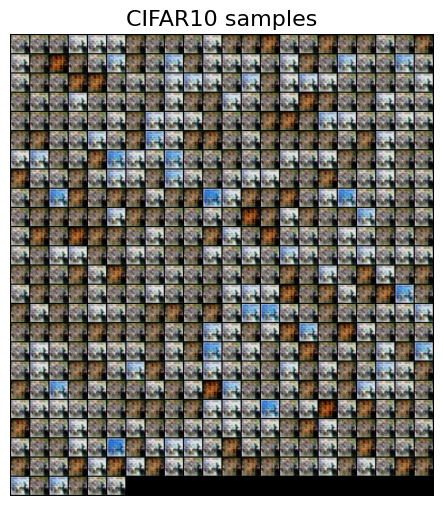

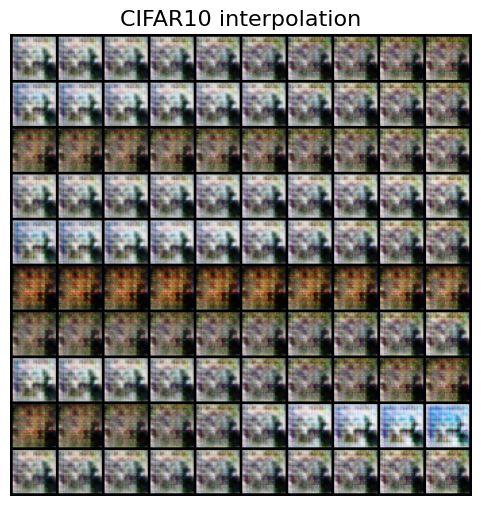

In [57]:
loss_g, loss_d_real, loss_d_fake = train_gan(gan_with_FKL)

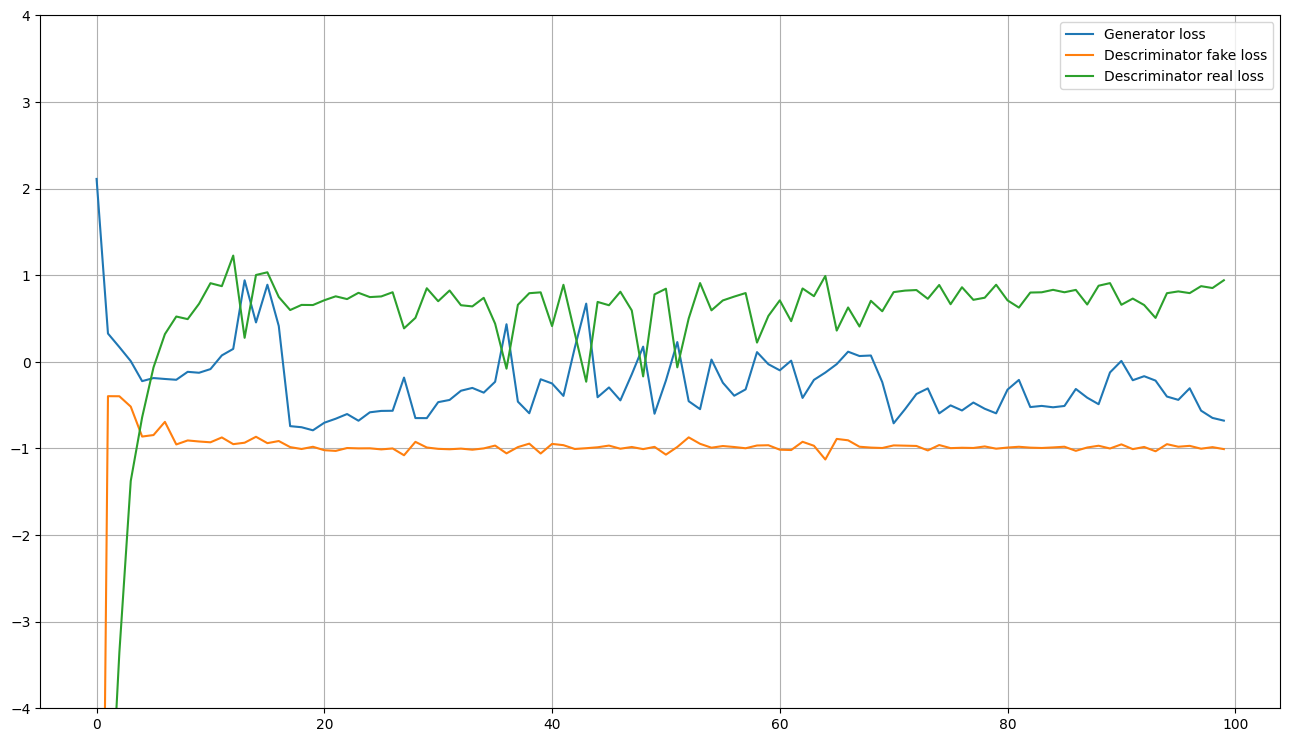

In [58]:
print_loss(loss_g, loss_d_real, loss_d_fake)

Обратная KL-дивергенция

$$
g_f(v) = -e^{(-v)}\\
f^*(x)= -1 -\log(-x)
$$

In [59]:
def rKL_gf(v):
    return -torch.exp(-v)

def rKL_f_star_gf(x):
    return -1 + x

In [60]:
gan_with_RKL = fGAN(input_shape=(3, 32, 32), batch_size=BATCH_SIZE, 
          noise_fn=noise_fn,
          data_fn=make_data_fn(),
          gf=rKL_gf,
          f_star_gf=rKL_f_star_gf,
          noise_dim=128,
          flw=1,
          non_saturating=False).to(device)

Epoch 91/100 (72s): G=0.000, Dr=-0.000, Df=-28.334


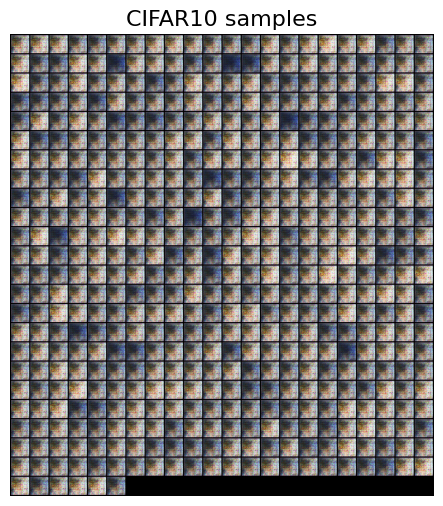

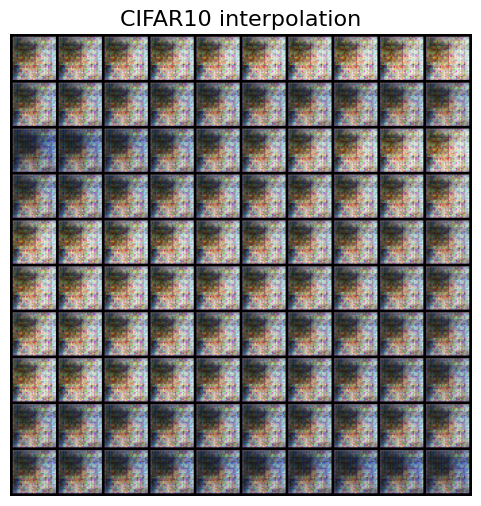

In [61]:
loss_g, loss_d_real, loss_d_fake = train_gan(gan_with_RKL)

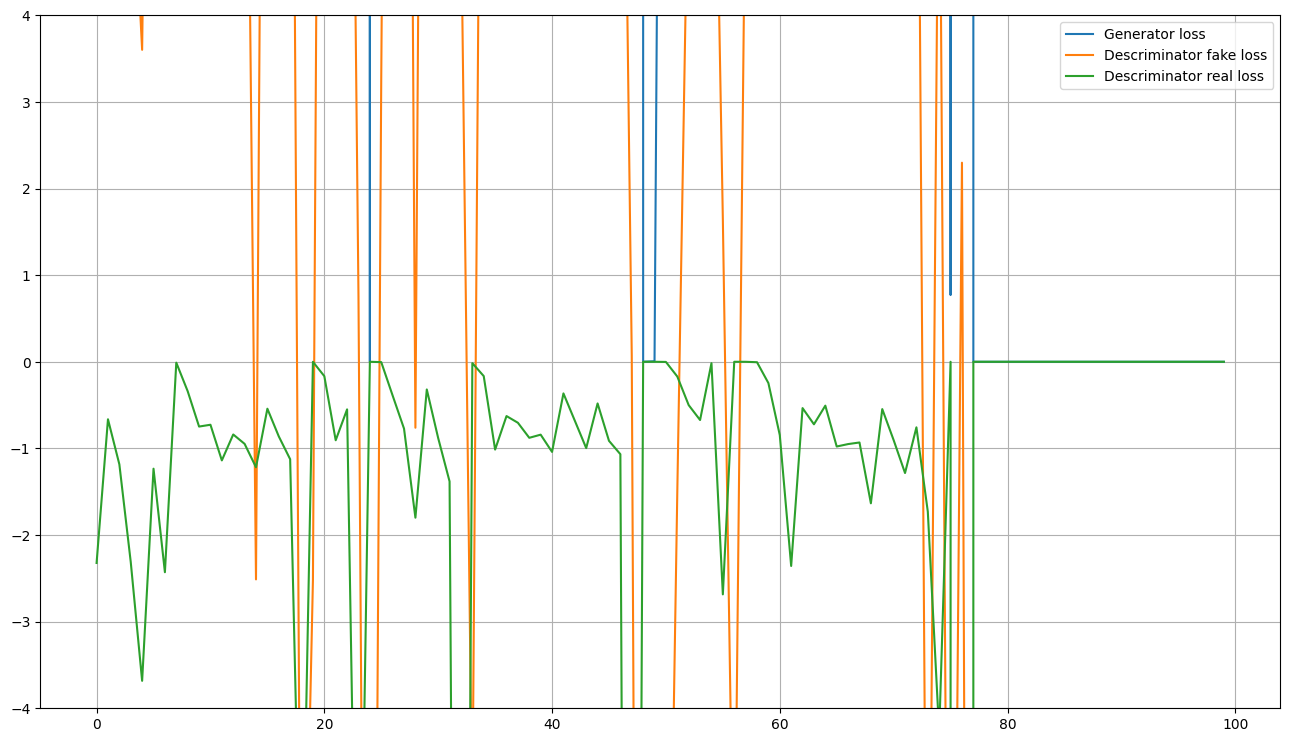

In [62]:
print_loss(loss_g, loss_d_real, loss_d_fake)

JS-дивергенция
$$
g_f(v) = \log(2) - \log(1 + e^{-v})\\
f^*(x)= - log(2- e^x)
$$

In [63]:
def JS_gf(v):
    two = torch.Tensor([2]).to(device)
    return torch.log(two) - torch.log(1 + torch.exp(-v))

def JS_f_star_gf(v):
    return -torch.log(2 - 2/(1 + torch.exp(-v)))

In [64]:
gan_with_JS = fGAN(input_shape=(3, 32, 32), batch_size=BATCH_SIZE, 
          noise_fn=noise_fn,
          data_fn=make_data_fn(),
          gf=JS_gf,
          f_star_gf=JS_f_star_gf,
          noise_dim=128,
          flw=1,
          non_saturating=False).to(device)

Epoch 91/100 (73s): G=0.656, Dr=0.004, Df=0.072


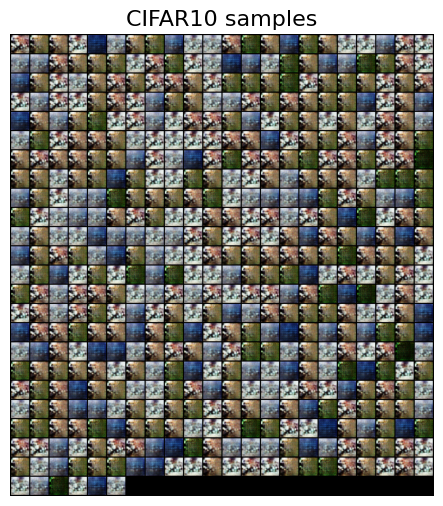

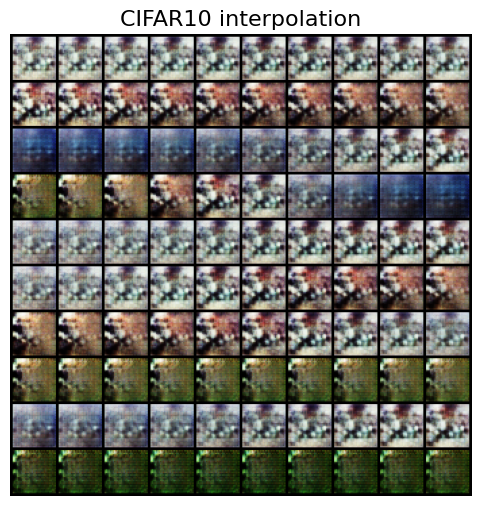

In [65]:
loss_g, loss_d_real, loss_d_fake = train_gan(gan_with_JS)

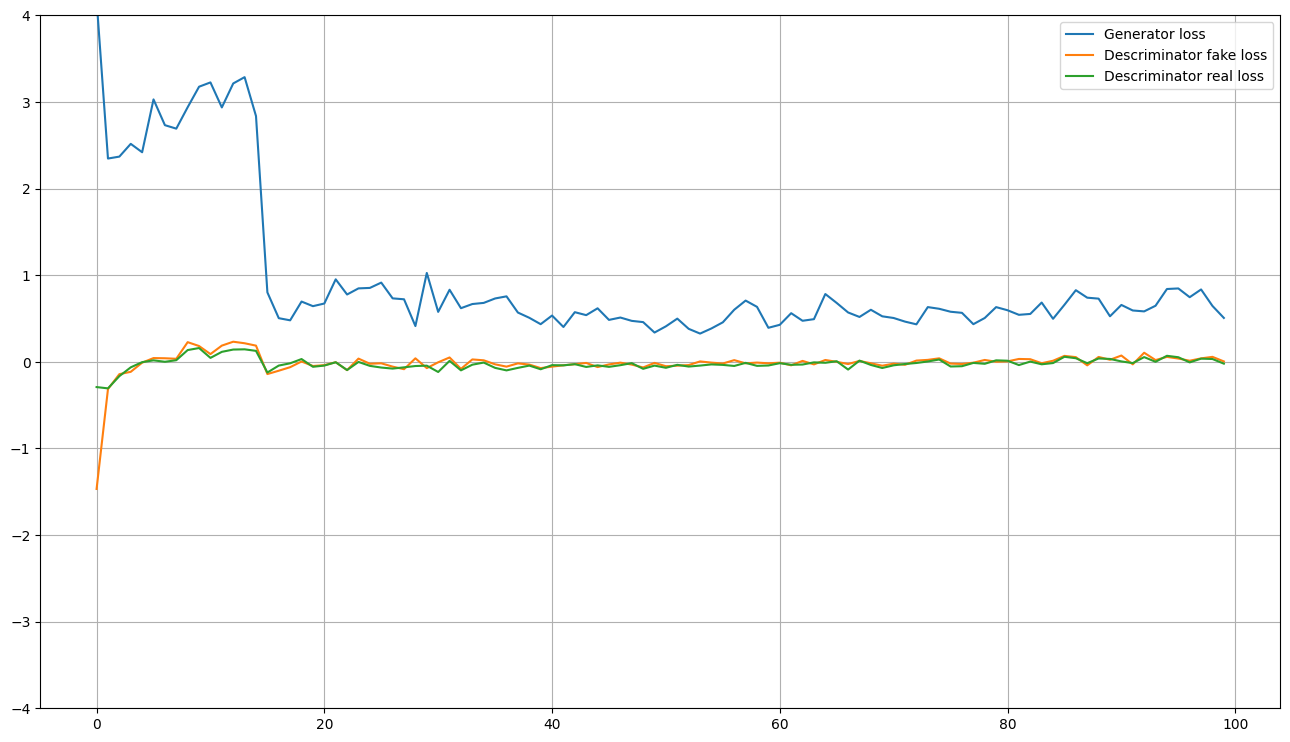

In [66]:
print_loss(loss_g, loss_d_real, loss_d_fake)

Пока что видно что модель обучается и на графиках видно что даже лосс генератора растет ( то что нужно), но видимо генератор и дискриминатор слишком простые. Попробую написать резнетовский блок еще раз.

In [67]:
class ConvBlock(nn.Module):
    def __init__(self, input_channel, output_channel, 
                 first_block:bool=False, last_block:bool=False) -> None:
        super().__init__()
        self.first_block = first_block
        self.last_block = last_block
        self.output_channel = output_channel
        self.block = nn.Sequential(
            nn.ConvTranspose2d(input_channel, 
                               (2 * input_channel + output_channel) // 2,
                               int(5 - first_block), 1, 0, bias=False),
            nn.BatchNorm2d((2 * input_channel + output_channel) // 2),
            nn.LeakyReLU(),
            # shape 4 x 4
            nn.ConvTranspose2d((2 * input_channel + output_channel) // 2,
                               (input_channel + 2 * output_channel) // 2,
                               3, 1, 0, bias=False),
            nn.BatchNorm2d((input_channel + 2 * output_channel) // 2),
            nn.LeakyReLU(),
            # shape 6 x 6
            nn.ConvTranspose2d((input_channel + 2 * output_channel) // 2,
                               output_channel,
                               3, 1, 0, bias=False),
            nn.BatchNorm2d(output_channel),
            nn.LeakyReLU()
            # shape 8 x 8
        )

        self.reflection = nn.ReflectionPad2d(4)
        if first_block:
            self.linear = nn.Linear(input_channel, output_channel * 8 * 8)

    
    def forward(self, x):
        y = self.block(x)
        if self.first_block:
            y += self.linear(x.squeeze(-1).squeeze(-1)).reshape(-1, self.output_channel, 8, 8)
        elif not self.last_block:
            y += self.reflection(torch.cat([x, x], dim=1))
        
        return y


class Generator(nn.Module):
    def __init__(self, noise_dim, out_shape) -> None:
        super().__init__()
        self.out_shape = out_shape
        ngf = noise_dim * 2
        self.net = nn.Sequential(
            ConvBlock(noise_dim, ngf, first_block=True),
            ConvBlock(ngf, ngf*2),
            ConvBlock(ngf*2, ngf*4),
            ConvBlock(ngf*4, out_shape[0], last_block=True),
            nn.Sigmoid()
        )

    
    def forward(self, x):
        x = x.unsqueeze(-1).unsqueeze(-1)
        img = self.net(x)
        assert img.shape[1:] == self.out_shape, "Generator output image has wrong shape"
        return img       
        

In [68]:
gan_with_FKL = fGAN(input_shape=(3, 32, 32), batch_size=BATCH_SIZE, 
          noise_fn=noise_fn,
          data_fn=make_data_fn(),
          gf=fKL_gf,
          f_star_gf=fKL_f_star_gf,
          noise_dim=32,
          flw=1,
          non_saturating=False).to(device)

Epoch 46/50 (870s): G=-21.059, Dr=-29.321, Df=-525654358.667


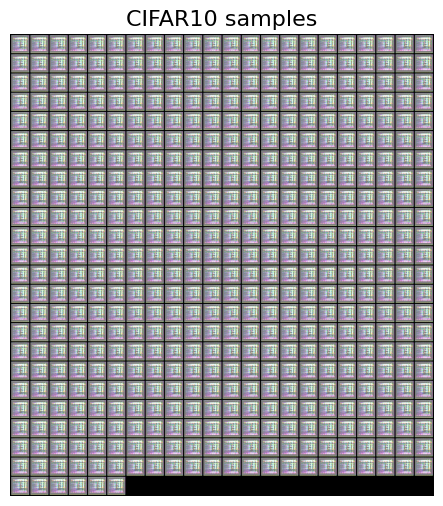

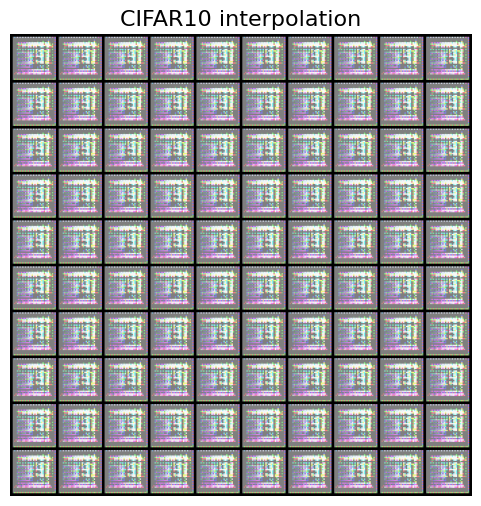

In [69]:
loss_g, loss_d_real, loss_d_fake = train_gan(gan_with_FKL, EPOCHS=50, show_step=5, discriminator_step=2)

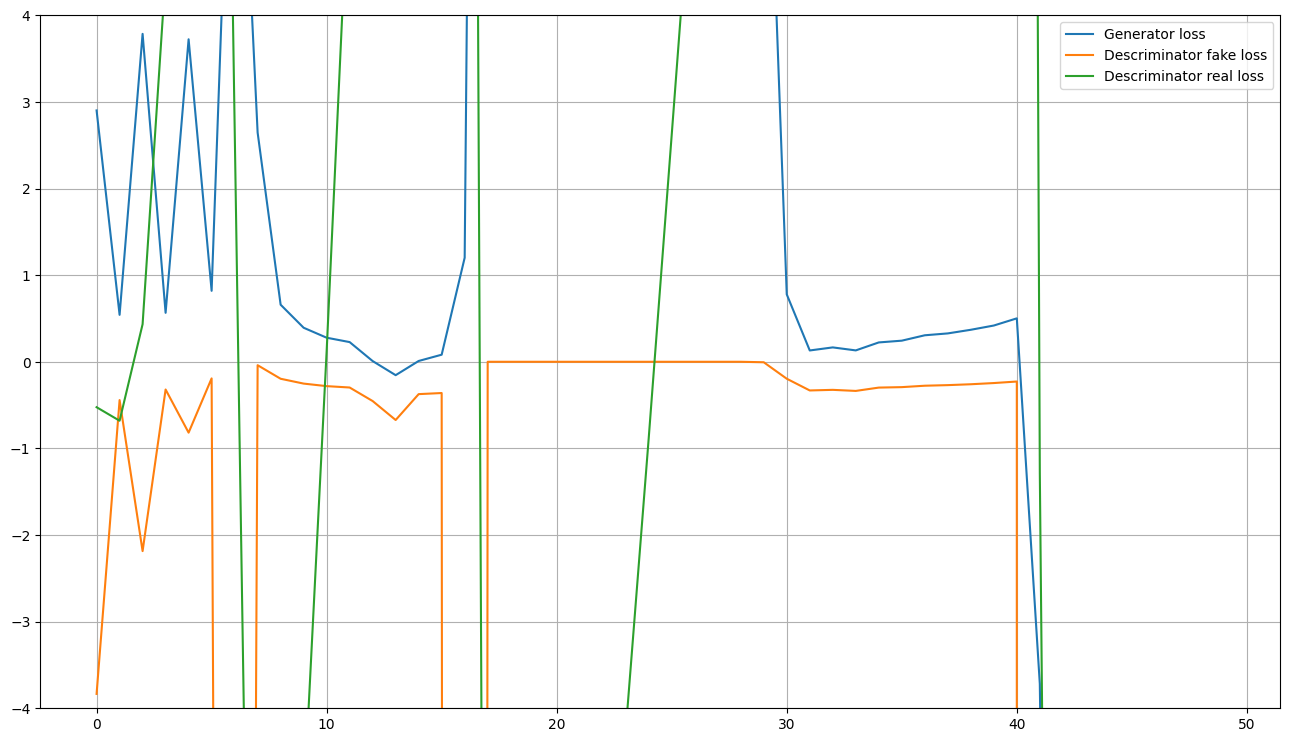

In [70]:
print_loss(loss_g, loss_d_real, loss_d_fake)

In [71]:
gan_with_RKL = fGAN(input_shape=(3, 32, 32), batch_size=BATCH_SIZE, 
          noise_fn=noise_fn,
          data_fn=make_data_fn(),
          gf=rKL_gf,
          f_star_gf=rKL_f_star_gf,
          noise_dim=32,
          flw=1,
          non_saturating=False).to(device)

Epoch 31/50 (572s): G=nan, Dr=nan, Df=nan


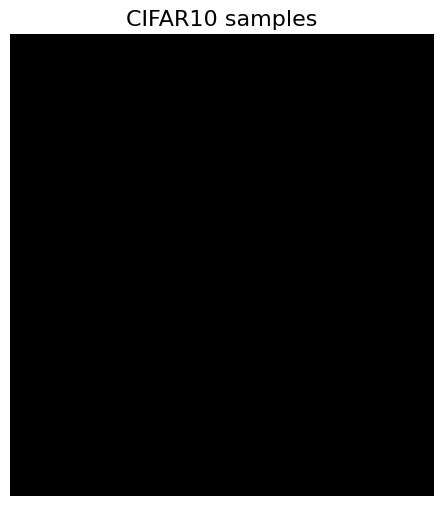

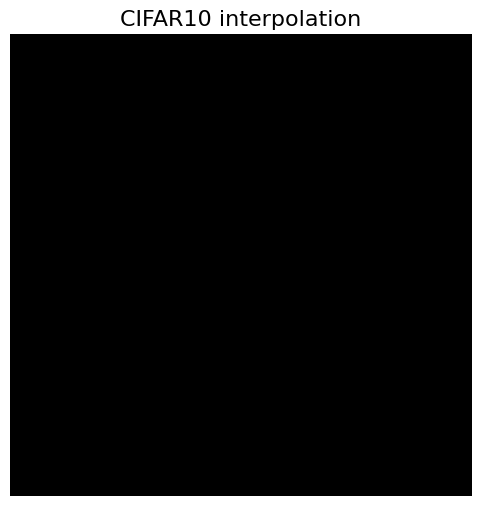

KeyboardInterrupt: 

In [72]:
loss_g, loss_d_real, loss_d_fake = train_gan(gan_with_RKL, EPOCHS=50, show_step=5, discriminator_step=2)

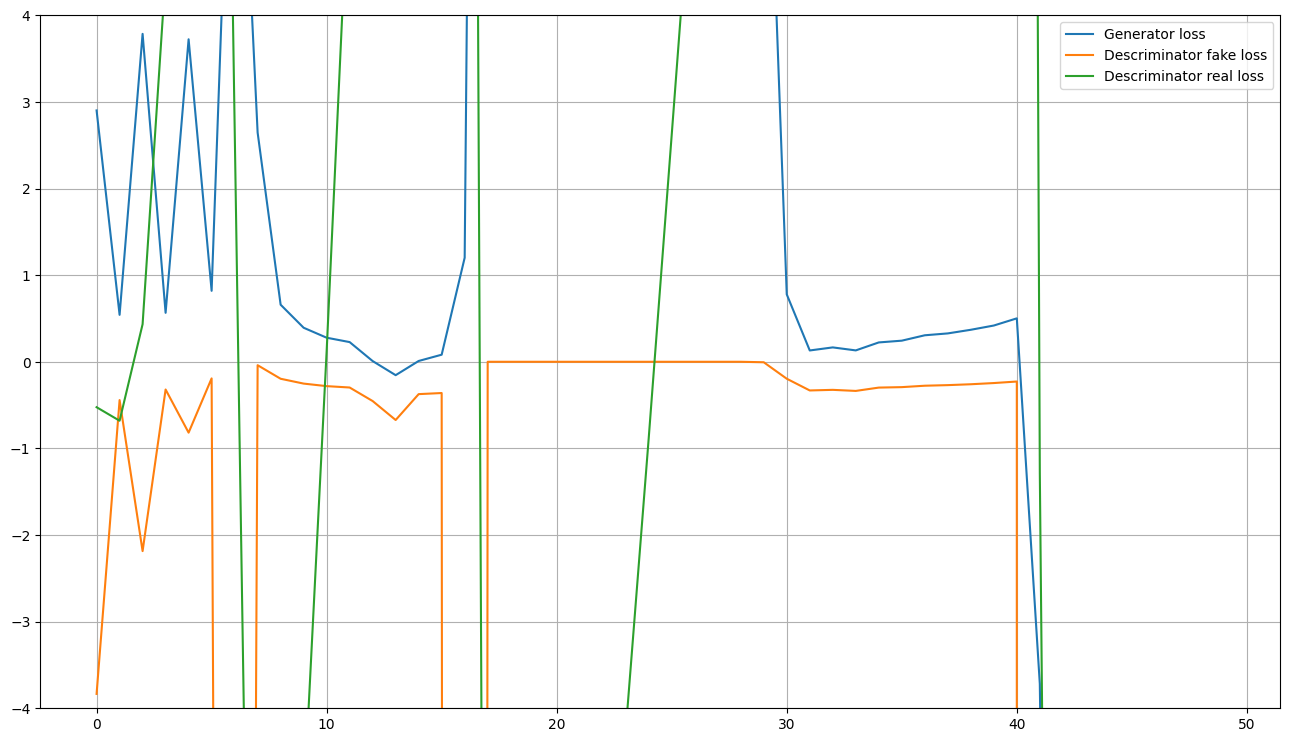

In [73]:
print_loss(loss_g, loss_d_real, loss_d_fake)

In [74]:
gan_with_JS = fGAN(input_shape=(3, 32, 32), batch_size=BATCH_SIZE, 
          noise_fn=noise_fn,
          data_fn=make_data_fn(),
          gf=JS_gf,
          f_star_gf=JS_f_star_gf,
          noise_dim=32,
          flw=1,
          non_saturating=False).to(device)

Epoch 46/50 (876s): G=nan, Dr=nan, Df=nan


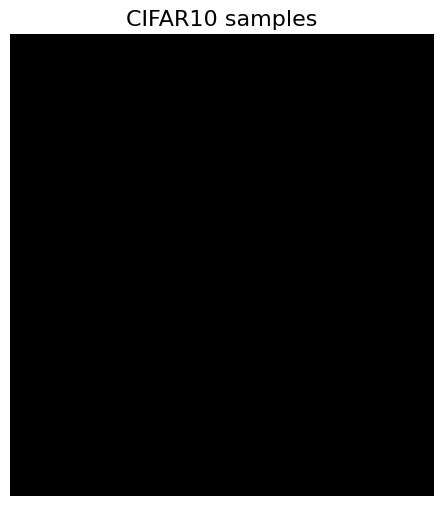

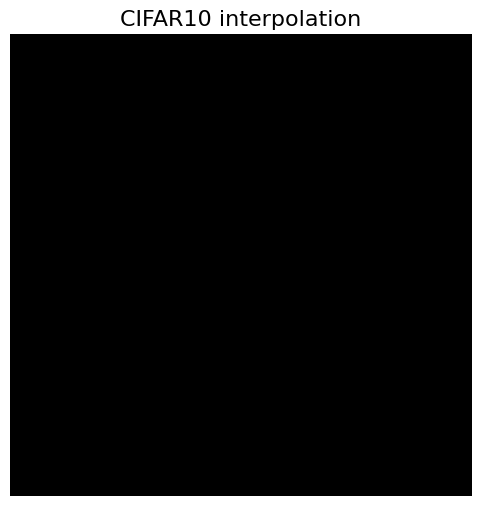

In [75]:
loss_g, loss_d_real, loss_d_fake = train_gan(gan_with_JS, EPOCHS=50, show_step=5, discriminator_step=2)

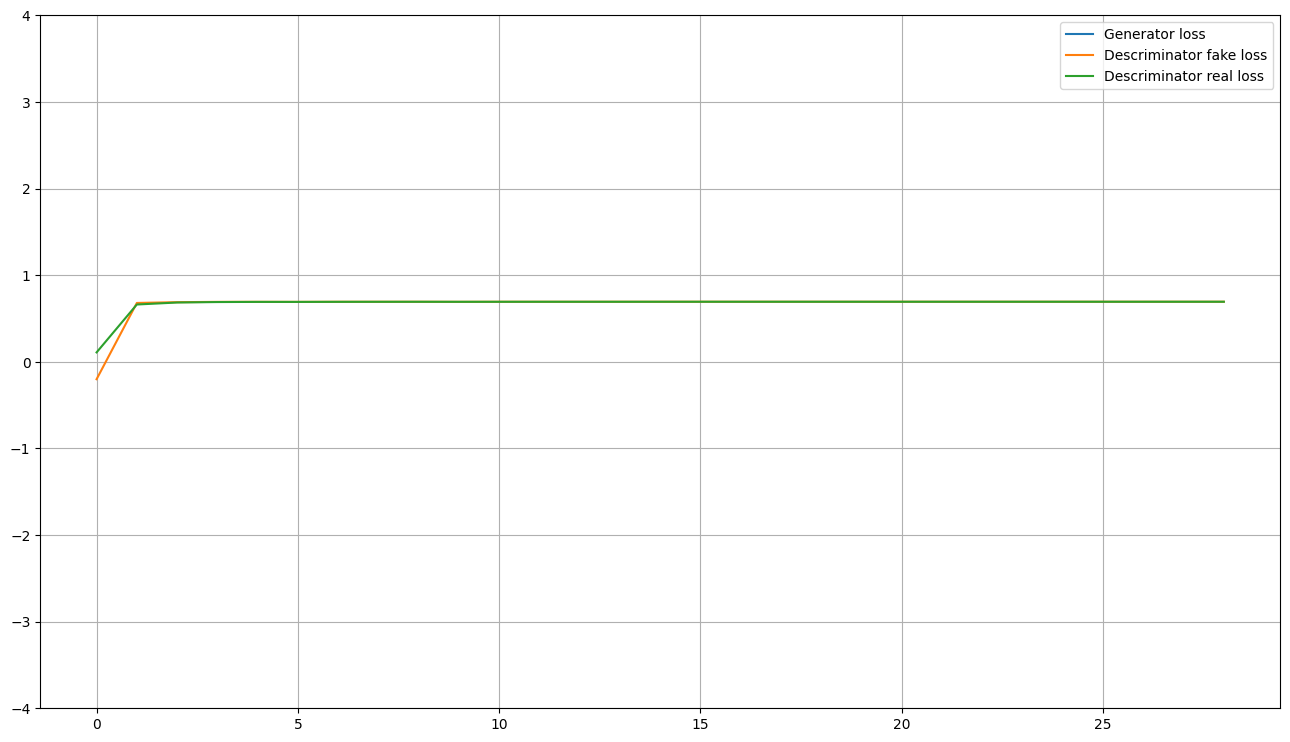

In [76]:
print_loss(loss_g, loss_d_real, loss_d_fake)

В итоге генератор оказался слишком сложным. Попробую его упростить, но это уже не в рамках этого домашнего задания. Еще хочется попробовать добавление случайных шумов. 

Я применил некоторые хинты как non saturating loss, использование LeakyReLU, скейлинг картинки и выхода генератора к одному спектру (да, для меня было не очевидно).
Да и в целом тема ганов обширна, кажется настраивать их можно бесконечно.